## Polynomial functions

Polynomial with all the metro KPI

In [1]:
#uncomment when will have latest version of the functions
from functions import *
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#calculate metro kpi coeffs
path = 'results/metro_kpi.csv'
metro_kpi = pd.read_csv(path)

metro_kpi['Date'] = pd.to_datetime(metro_kpi['Date'])
metro_kpi = metro_kpi[['Date', 'ROTP', 'RailReliability', 'MetroAccessOTP',
       'EscalatorAvail', 'ElevatorAvail', 'TotalInjuries', 'Crime', 'Metro']]

#convert % to float
metro_kpi['ElevatorAvail'] = [float(x.strip('%'))/100 for x in metro_kpi['ElevatorAvail']]

metro_kpi.head()

,Date,ROTP,RailReliability,MetroAccessOTP,EscalatorAvail,ElevatorAvail,TotalInjuries,Crime,Metro
0,2011-01-01,0.879,48241,0.901,0.888,0.963,2.08,6.39,21082553
1,2011-02-01,0.887,37703,0.890,0.866,0.960,1.66,4.68,21228262
2,2011-03-01,0.910,50328,0.913,0.869,0.969,2.16,3.96,26170157
3,2011-04-01,0.909,39302,0.912,0.862,0.964,2.21,4.72,25656797
4,2011-05-01,0.909,37355,0.922,0.825,0.974,1.69,7.32,24342603


X: all KPIs, Y: Ridership

In [ ]:
#create all the graphs and combined coeffs table for metro_kpi
kpi = calcPolyY(metro_kpi,'Metro',lw=0)
kpi.to_csv('results/metro_kpi_polyY_coefs.csv')
kpi

X: Date, Y: all KPIs

In [ ]:
#create all the graphs and combined coeffs table for metro_kpi
kpi = calcPoly(metro_kpi,'Date')
kpi.to_csv('results/metro_kpi_poly_coefs.csv')
kpi

Polynomial with all combined ridership data

In [4]:
path = 'results/combined.csv'
combined_df = pd.read_csv(path)

combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df.head()

,Date,Bus,Metro,Taxi,Uber
0,2011-01-01,NaN,21082553.0,NaN,NaN
1,2011-02-01,NaN,21228262.0,NaN,NaN
2,2011-03-01,NaN,26170157.0,NaN,NaN
3,2011-04-01,NaN,25656797.0,NaN,NaN
4,2011-05-01,NaN,24342603.0,NaN,NaN


In [ ]:
#create all the graphs and combined coeffs table for combined data
combined = calcPoly(combined_df,Mtick=True)
combined.to_csv('results/combined_poly_coefs.csv')

X: all KPIs, Y: Uber

In [ ]:
uber_kpi = pd.merge(combined_df[['Date','Uber']],metro_kpi.drop(columns='Metro'),on='Date',how='outer')
uber_kpi

kpi = calcPolyY(uber_kpi,'Uber',lw=0,Mtick=True)
kpi.to_csv('results/uber_kpi_polyY_coefs.csv')

X: all KPIs, Y: Taxi

In [ ]:
taxi_kpi = pd.merge(combined_df[['Date','Taxi']],metro_kpi.drop(columns='Metro'),on='Date',how='outer')
taxi_kpi

kpi = calcPolyY(taxi_kpi,'Taxi',lw=0,Mtick=True)
kpi.to_csv('results/taxi_kpi_polyY_coefs.csv')

X: all KPIs, Y: Bus

In [ ]:
bus_kpi = pd.merge(combined_df[['Date','Bus']],metro_kpi.drop(columns='Metro'),on='Date',how='outer')
bus_kpi

kpi = calcPolyY(bus_kpi,'Bus',lw=0,Mtick=True)
kpi.to_csv('results/bus_kpi_polyY_coefs.csv')

## Linear Regression

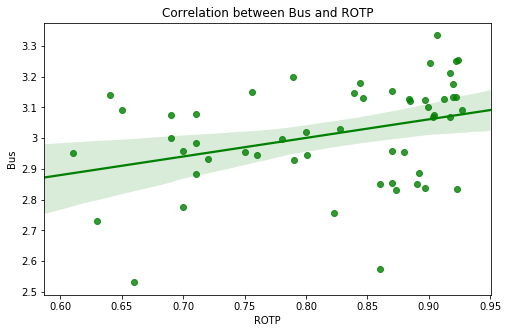

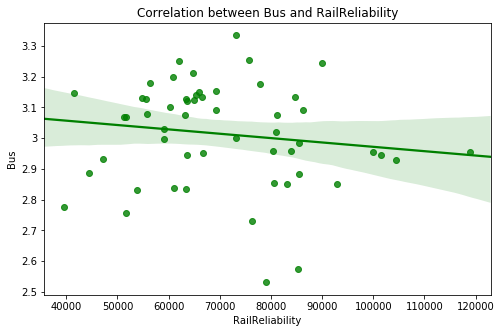

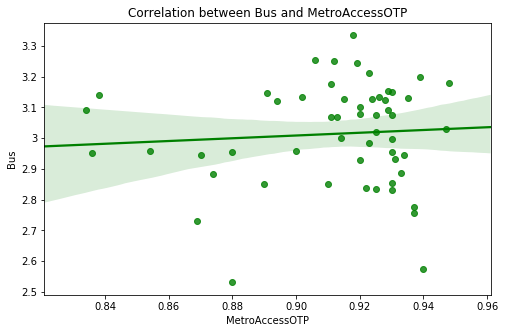

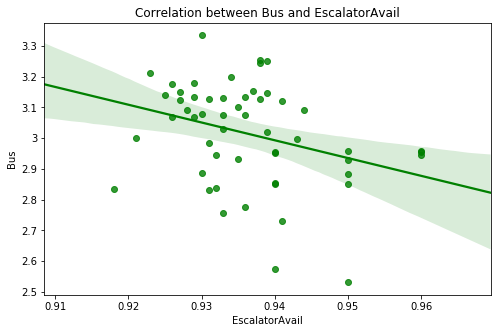

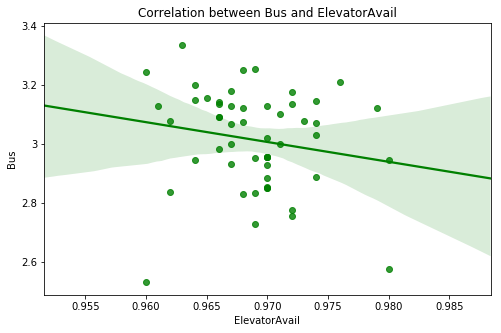

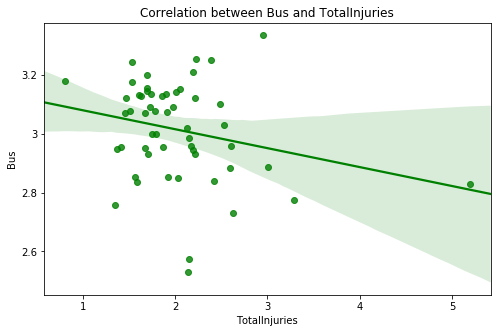

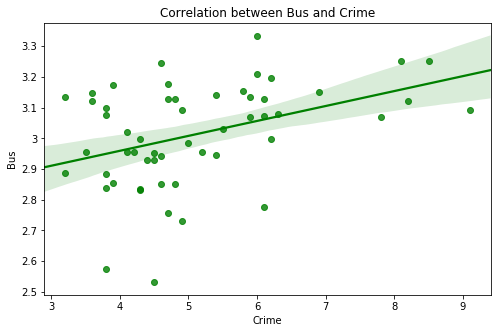

In [7]:
bus_kpi = pd.merge(combined_df[['Date','Bus']],metro_kpi.drop(columns='Metro'),on='Date',how='outer')
bus_kpi = bus_kpi.set_index('Date')

#kpi = linear_regression(bus_kpi,0)

#set column names for the plot excluding 'Date' column [1:]
columns = bus_kpi.columns.tolist()[1:]

result_df = bus_kpi.copy()

for column in columns:
    path_to_plot = 'results/plots/linear_regression_'+column+'_Bus.png'
    plot = linear_regression_plot(bus_kpi[['Bus',column]],0)
    plot.savefig(path_to_plot,dpi=150,transparent=True,bbox_inches='tight')

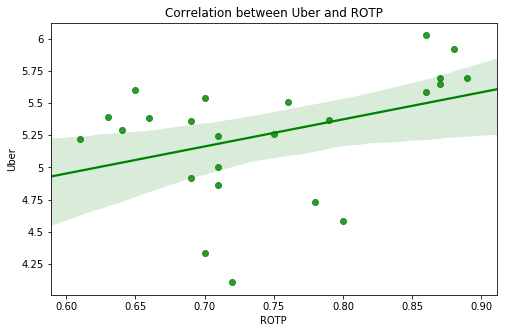

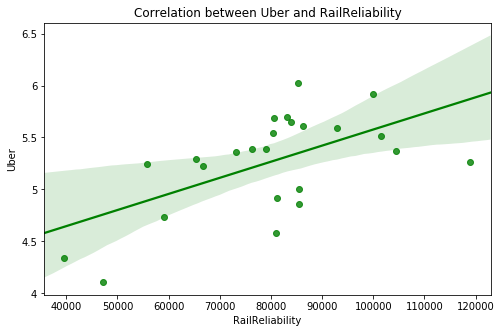

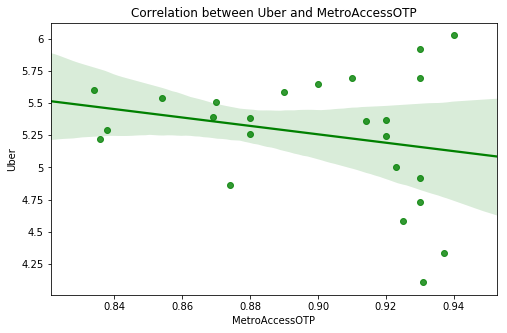

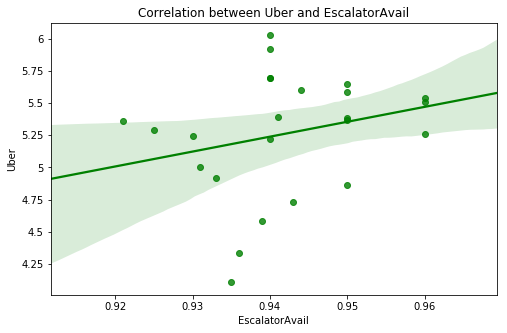

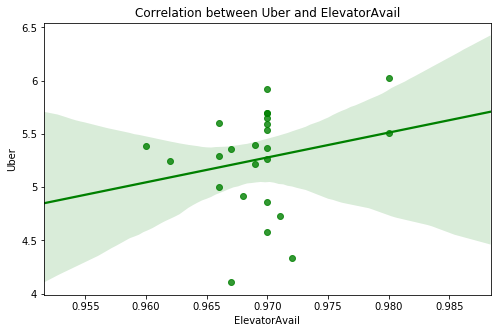

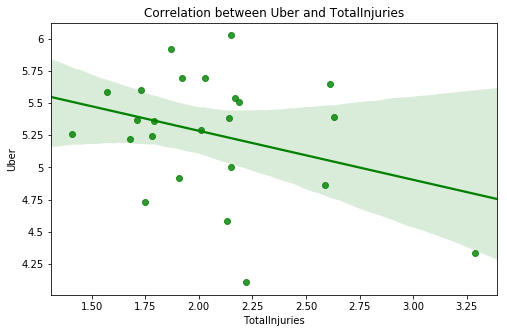

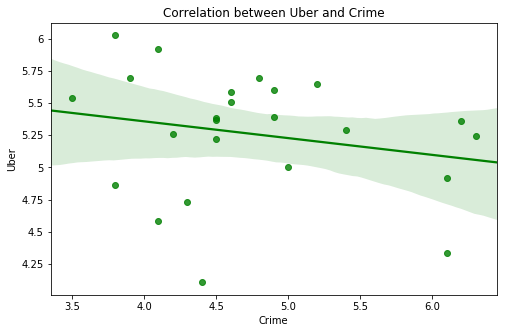

In [11]:
uber_kpi = pd.merge(combined_df[['Date','Uber']],metro_kpi.drop(columns='Metro'),on='Date',how='outer')
uber_kpi = uber_kpi.set_index('Date')

#set column names for the plot excluding 'Date' column [1:]
columns = uber_kpi.columns.tolist()[1:]

result_df = uber_kpi.copy()

for column in columns:
    path_to_plot = 'results/plots/linear_regression_'+column+'_Uber.png'
    plot = linear_regression_plot(result_df[['Uber',column]],0)
    plot.savefig(path_to_plot,dpi=150,transparent=True,bbox_inches='tight')

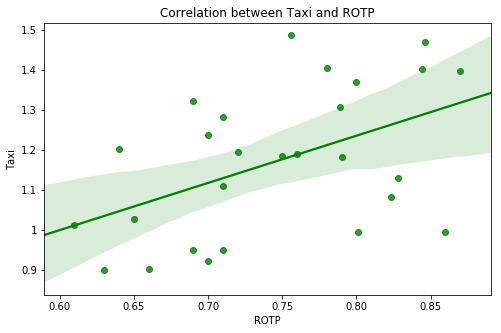

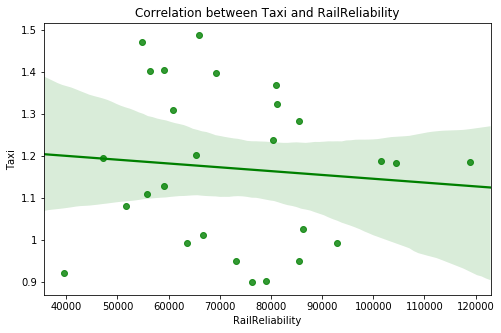

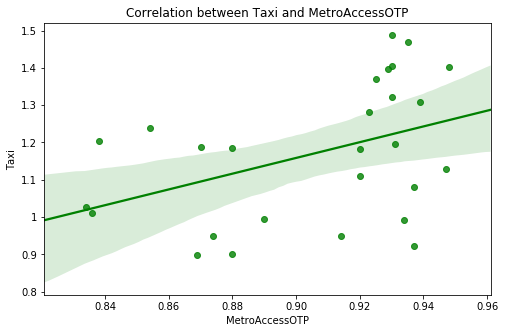

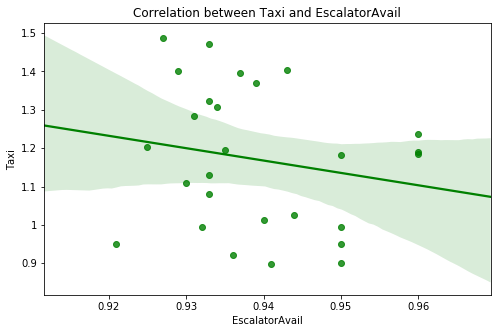

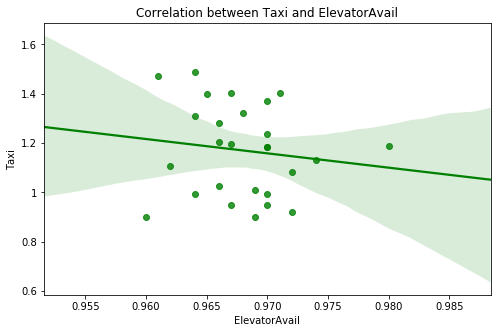

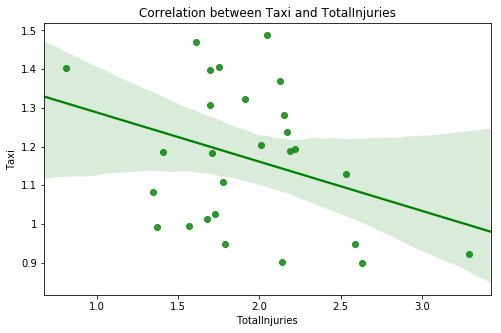

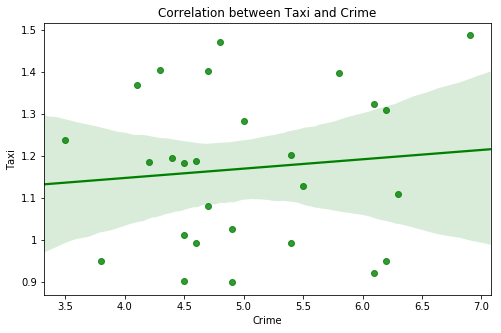

In [12]:
taxi_kpi = pd.merge(combined_df[['Date','Taxi']],metro_kpi.drop(columns='Metro'),on='Date',how='outer')
taxi_kpi = taxi_kpi.set_index('Date')

#set column names for the plot excluding 'Date' column [1:]
columns = taxi_kpi.columns.tolist()[1:]

result_df = taxi_kpi.copy()

for column in columns:
    path_to_plot = 'results/plots/linear_regression_'+column+'_Taxi.png'
    plot = linear_regression_plot(result_df[['Taxi',column]],0)
    plot.savefig(path_to_plot,dpi=150,transparent=True,bbox_inches='tight')